# 0. Imports

In [1]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
#import wave
#import pyaudio
import numpy as np
from fpdf import FPDF
from glob import glob
import os
from datetime import date
import calendar


In [2]:
data_dir = '/Users/bryan.gonzalez/PycharmProjects/MOBI2024/CUNY_FACIAL/Data/real_subjects'
subject_xdf_paths = glob(os.path.join(data_dir,'*', '*.xdf'))
subject_xdf_paths.sort()
sub_ids = [x.split('/')[-1].split('_')[0] for x in subject_xdf_paths]
df = pd.DataFrame({
    'Subject': sub_ids, 
    'Date':[0] * len(sub_ids),
    'EGI NetAmp 0':[0] * len(sub_ids),
    'OpenSignals':[0] * len(sub_ids),
    'WebcamStream':[0]  * len(sub_ids),
    'Tobii':[0] * len(sub_ids),
    'Stimuli_Markers':[0] * len(sub_ids),
    'Microphone':[0] * len(sub_ids)})



In [3]:
xdfs = {}
for i, subject in enumerate(sub_ids):
    data, header = pyxdf.load_xdf(subject_xdf_paths[i])
    xdfs[subject] = data
    streams_collected = [stream['info']['name'][0] for stream in data]
    
    df.loc[df['Subject'] == subject, 'datetime'] = header['info']['datetime'][0]
    for s in streams_collected:
        df.loc[df['Subject'] == subject, s] = 1

df.rename(columns={
    'EGI NetAmp 0':'EEG', 
    'OpenSignals':'Physiology', 
    'WebcamStream':'Video', 
    'Tobii':'EyeTracker', 
    'Stimuli_Markers':'Stimuli',
    'Microphone':'Audio'}, inplace=True)

In [4]:
df['date'] = pd.to_datetime(df['datetime']).dt.date
df.sort_values(by='date', inplace=True)

In [5]:
df['count'] = [len(df.loc[df.date <= d]) for d in df.date]

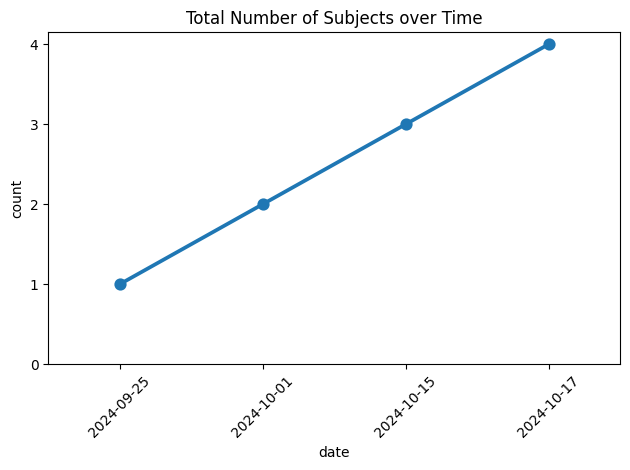

In [6]:
sns.pointplot(x='date', y='count', data=df)
plt.xticks(rotation=45);
# give the plot a title

plt.title('Total Number of Subjects over Time')
# make sure y axis is integers
plt.yticks(np.arange(0, df['count'].max() + 1, 1));
plt.tight_layout()
plt.savefig('data_collection.png')

In [7]:
streams = ['EEG', 'Physiology', 'Video', 'EyeTracker', 'Stimuli', 'Audio']
calculated_values = {}
# Get percentage of subjects that have each stream
calculated_values = {s: f'{df[s].sum() / len(df) * 100} %'  for s in streams}
calculated_values['N'] = df.Subject.nunique()
# Get the number of subjects in the last week
calculated_values['n_lastweek'] = df.loc[df.date >= date.today() - pd.Timedelta(7, 'D')].Subject.nunique()
# Get the percentage of subjects that have all 6 data streams
calculated_values['all_streams'] = f'{len(df.loc[df[streams].sum(axis=1) == 6]) / len(df) * 100} %'


## Subjects with each experimental block

In [20]:
def get_stim(xdfs, subject):
    data = xdfs[subject]
    streams_collected = [stream['info']['name'][0] for stream in data]
    stim_dat = data[streams_collected.index('Stimuli_Markers')]
    stim_df = pd.DataFrame(stim_dat['time_series'])
    stim_df.rename(columns={0: 'trigger'}, inplace=True)
    events = {
            200: 'Onset_ExperimentStart',
            10: 'Onset_RestingState',
            11: 'Offset_RestingState',
            500: 'Onset_StoryListening',
            501: 'Offset_StoryListening',
            100: 'Onset_10second_rest',
            101: 'Offset_10second_rest', 
            20: 'Onset_CampFriend',
            21: 'Offset_CampFriend',
            30: 'Onset_FrogDissection',
            31: 'Offset_FrogDissection',
            40: 'Onset_DanceContest',
            41: 'Offset_DanceContest',
            50: 'Onset_ZoomClass',
            51: 'Offset_ZoomClass',
            60: 'Onset_Tornado',
            61: 'Offset_Tornado',
            70: 'Onset_BirthdayParty',
            71: 'Offset_BirthdayParty',
            300: 'Onset_subjectInput',
            301: 'Offset_subjectInput',
            302: 'Onset_FavoriteStory',
            303: 'Offset_FavoriteStory',
            304: 'Onset_WorstStory',
            305: 'Offset_WorstStory',
            400: 'Onset_impedanceCheck',
            401: 'Offset_impedanceCheck',
            80: 'Onset_SocialTask',
            81: 'Offset_SocialTask',
            201: 'Offset_ExperimentEnd',
        }

    story_onsets = [20, 30, 40, 50, 60, 70]

    # relabel the event if the trigger is in the events dictionary, else if 
    stim_df['event'] = stim_df['trigger'].apply(lambda x: events[x] if x in events.keys() else 'Bx_input')
    # relabel the event as a psychopy timestamp if the trigger is greater than 5 digits
    stim_df.loc[stim_df.trigger.astype(str).str.len() > 5, 'event'] = 'psychopy_time_stamp'
    stim_df['lsl_time_stamp'] = stim_dat['time_stamps']
    stim_df['time'] = (stim_dat['time_stamps'] - stim_dat['time_stamps'][0])/1000
    return stim_df

In [34]:

trials = ['RestingState', 'StoryListening', 'CampFriend', 'FrogDissection', 'DanceContest', 'ZoomClass', 'Tornado', 'BirthdayParty','SocialTask']
for subject in sub_ids:
    stim = get_stim(xdfs, subject)
    for trial in trials:
        # Find out if event columns contains Onset and Offset for RestingState
        df['has_'+trial] = stim.event.str.contains('Onset_'+ trial).sum() + stim.event.str.contains('Offset_'+ trial).sum() == 2


In [40]:
trials = ['RestingState', 'StoryListening', 'CampFriend', 'FrogDissection', 'DanceContest', 'ZoomClass', 'Tornado', 'BirthdayParty','SocialTask']

for t in trials:
    calculated_values['Completed '+t] =  f'{df['has_'+t].sum() / len(df) * 100} %'  

# Goal
To create a pdf report with values calculated in this python code

In [47]:
def create_pdf(values, file_name = "output_testfile.pdf"):
    pdf = FPDF()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page()
    #set font for the title
    pdf.set_font("Arial", size=12)
    #Title of the document
    today = date.today()
    today = today.strftime("%B %d, %Y")
    pdf.set_fill_color(220, 220, 220)  # RGB values for the color
    pdf.cell(180, 10, f"CUNY Data Report, {calendar.day_name[date.today().weekday()]}, {today} ",ln=True, align='C', border=1, fill=True)
    pdf.cell(180, 5, f"N:{values['N']}",ln=True, align='L', border=1)
    pdf.cell(180, 5, f"New Subjects Last Week:{values['n_lastweek']}",ln=True, align='L', border=1)

    # Step 3: Insert the plot image into the PDF
    # The parameters are (x-position, y-position, width, height)
    pdf.image('data_collection.png', x=90, y=20, w=100, h=80)
    pdf.ln(75)
    pdf.cell(180, 5, txt="Percentage of Subjects with each Data Stream", ln=True, align='L', border=1, fill=True)
    pdf.ln(3)
    pdf.cell(180, 5, txt= f"All 6 streams: {values['all_streams']}", ln=True, align='L' , border=1)

    # add calculated values
    for key in ['EEG', 'Physiology', 'Video', 'EyeTracker', 'Stimuli', 'Audio']:
        pdf.ln(3)
        pdf.cell(180, 5, txt= f"{key}" + " : " + str(values[key]), ln=True, align='L' , border=1)

    # Resting State
    pdf.ln(5)
    pdf.cell(180, 5, txt=f"Completed Resting State: {values['Completed RestingState']}%", ln=True, align='L', border=1, fill=False)
    # Story State
    pdf.ln(5)
    pdf.cell(180, 5, txt=f"Completed Story Listening: {values['Completed StoryListening']}%", ln=True, align='L', border=1, fill=False)
    # Resting State
    pdf.ln(5)
    pdf.cell(180, 5, txt=f"Completed Social Task: {values['Completed SocialTask']}%", ln=True, align='L', border=1, fill=False)

    pdf.output(file_name)

In [48]:
create_pdf(calculated_values)